# Usage notebook

This notebook will analyse the general usage of the assistant in the participating courses

In [20]:
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from getpass import getpass
import pandas as pd

## Load the data from the database

In [12]:
# Configure the database
DB_TYPE = 'postgresql'
DB_DRIVER = 'psycopg2'
DB_USER = 'postgres'
DB_PASS = getpass('Enter your database password: ')
DB_HOST = 'localhost'
DB_PORT = '5432'
DB_NAME = 'kthassistant_local'

DATABASE_URL = f'{DB_TYPE}+{DB_DRIVER}://{DB_USER}:{DB_PASS}@{DB_HOST}:{DB_PORT}/{DB_NAME}'
engine = create_engine(DATABASE_URL)

In [15]:
# Load all data, re-run this to refresh
tables = [
    'chat_configs',
    'chats',
    'content',
    'cookies',
    'courses',
    'faq_snapshots',
    'faqs',
    'feedback',
    'feedback_questions',
    'messages',
    'migratehistory',
    'prompt_handles',
    'sessions',
    'snapshots',
    'urls'
]

dataframes = {}
for table in tqdm(tables):
    dataframes[table] = pd.read_sql_table(table, engine)

  0%|          | 0/15 [00:00<?, ?it/s]

In [18]:
# Print the structure
for table, df in dataframes.items():
    print(f"Structure of DataFrame for table `{table}`")
    print(df.info())
    print("\n")

Structure of DataFrame for table `chat_configs`
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15 entries, 0 to 14
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   id              15 non-null     int64         
 1   created_at      15 non-null     datetime64[ns]
 2   modified_at     15 non-null     datetime64[ns]
 3   is_active       15 non-null     bool          
 4   llm_model_name  15 non-null     object        
 5   index_type      15 non-null     object        
dtypes: bool(1), datetime64[ns](2), int64(1), object(2)
memory usage: 747.0+ bytes
None


Structure of DataFrame for table `chats`
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4891 entries, 0 to 4890
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   id                4891 non-null   int64         
 1   created_at        4891 non-nu

## Number of chats per day (cummulative)

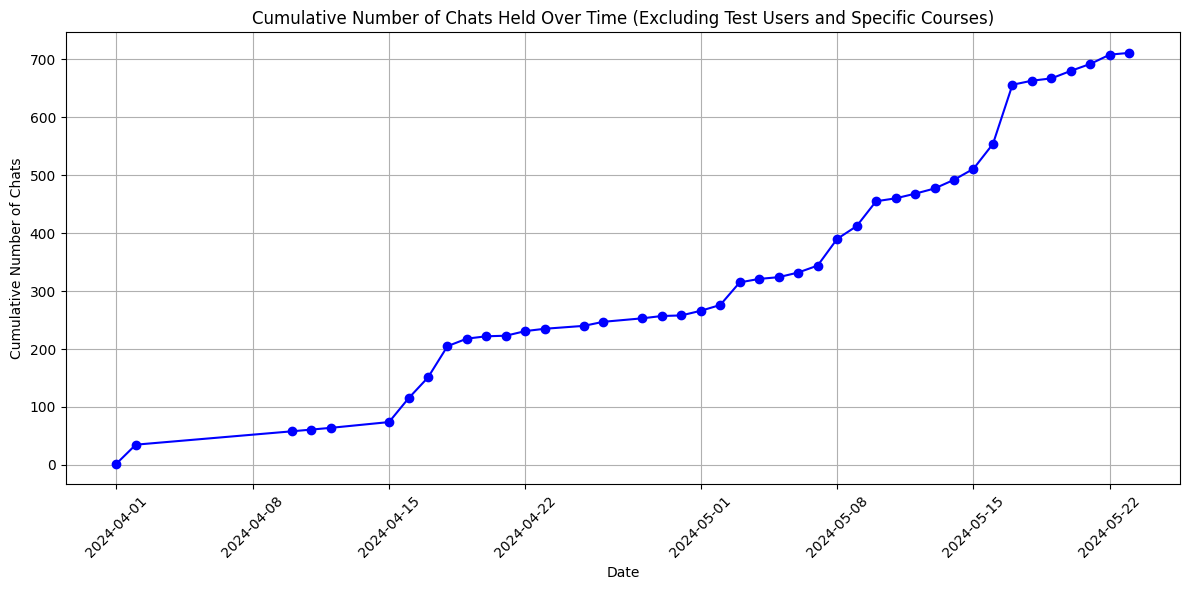

In [55]:
df_chats = dataframes['chats']
df_sessions = dataframes['sessions']
df_courses = dataframes['courses']

df_chats['created_at'] = pd.to_datetime(df_chats['created_at'])

df_merged = pd.merge(df_chats, df_sessions[['id', 'is_test_user']], left_on='session_id', right_on='id', how='left')

df_filtered = df_merged[df_merged['is_test_user'] == False].copy()

# Exclude ID 1: DD2445 Complexity Theory 7.5 credits
# Exclude ID 6: DA231X Degree Project in Computer Science and Engineering, Second Cycle 30.0 credits
# These were just used for testing, not actually included in the study
df_filtered = df_filtered[~df_filtered['course_id'].isin([1, 6])]

chats_per_day_filtered = df_filtered.groupby(df_filtered['created_at'].dt.date).size()
chats_per_day_cumulative = chats_per_day_filtered.cumsum()

plt.figure(figsize=(12, 6))
plt.plot(chats_per_day_cumulative.index, chats_per_day_cumulative.values, marker='o', linestyle='-', color='b')
plt.title('Cumulative Number of Chats Held Over Time (Excluding Test Users and Specific Courses)')
plt.xlabel('Date')
plt.ylabel('Cumulative Number of Chats')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

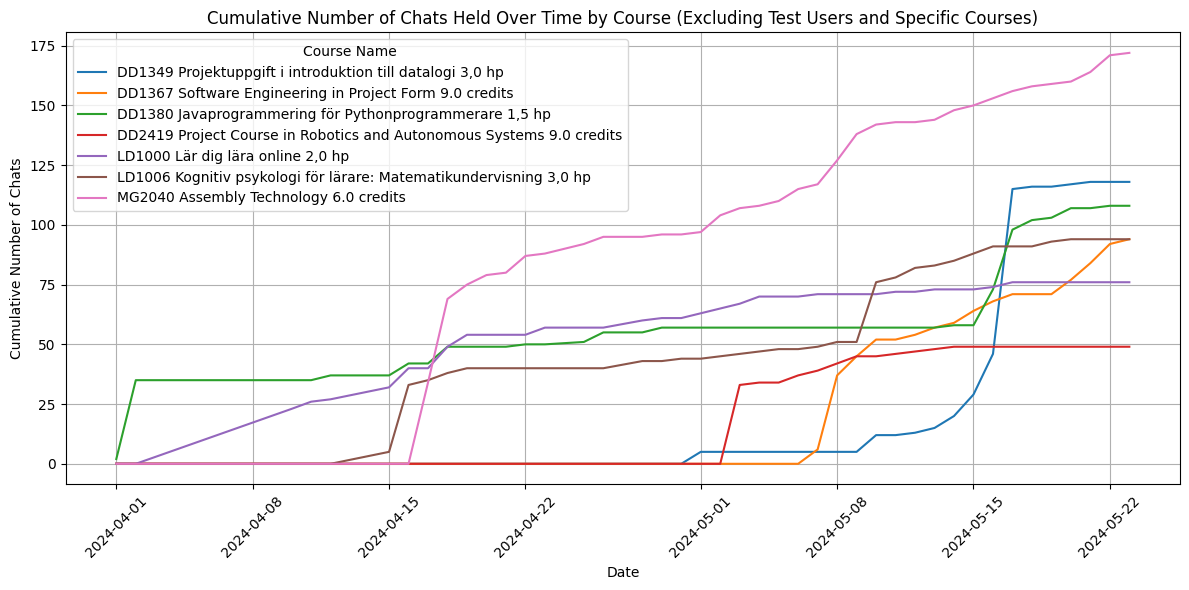

In [53]:
df_chats = dataframes['chats']
df_sessions = dataframes['sessions']
df_courses = dataframes['courses']

df_chats['created_at'] = pd.to_datetime(df_chats['created_at'])

df_merged = pd.merge(df_chats, df_sessions[['id', 'is_test_user']], left_on='session_id', right_on='id', how='left', suffixes=('', '_session'))

df_filtered = df_merged[df_merged['is_test_user'] == False].copy()

df_filtered_with_names = pd.merge(df_filtered, df_courses, left_on='course_id', right_on='id', how='left', suffixes=('', '_course'))

# Exclude ID 1: DD2445 Complexity Theory 7.5 credits
# Exclude ID 6: DA231X Degree Project in Computer Science and Engineering, Second Cycle 30.0 credits
# These were just used for testing, not actually included in the study
df_filtered_with_names = df_filtered_with_names[~df_filtered_with_names['course_id'].isin([1, 6])]

chats_per_day_per_course_name = df_filtered_with_names.groupby(['name', df_filtered_with_names['created_at'].dt.date]).size().unstack(fill_value=0)

cumulative_chats_per_course_name = chats_per_day_per_course_name.cumsum(axis=1).T

plt.figure(figsize=(12, 6))
for course_name in cumulative_chats_per_course_name.columns:
    plt.plot(cumulative_chats_per_course_name.index, cumulative_chats_per_course_name[course_name], linestyle='-', label=course_name)

plt.title('Cumulative Number of Chats Held Over Time by Course (Excluding Test Users and Specific Courses)')
plt.xlabel('Date')
plt.ylabel('Cumulative Number of Chats')
plt.legend(title='Course Name')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Chats per week

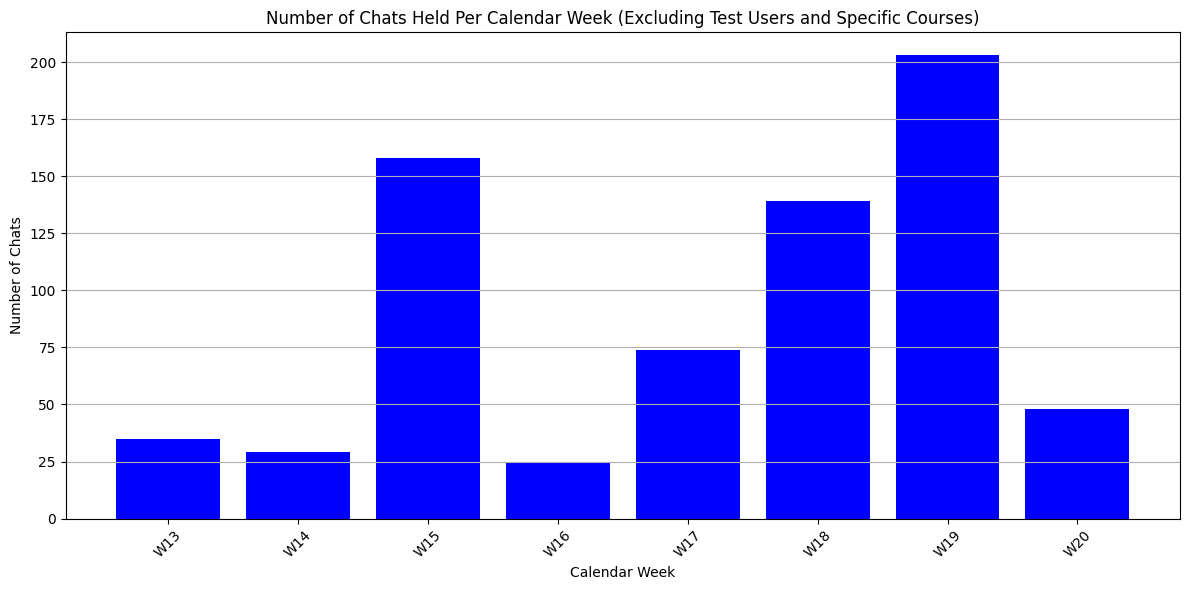

In [59]:
df_chats = dataframes['chats']
df_sessions = dataframes['sessions']

df_chats['created_at'] = pd.to_datetime(df_chats['created_at'])

df_merged = pd.merge(df_chats, df_sessions[['id', 'is_test_user']], left_on='session_id', right_on='id', how='left')

df_filtered = df_merged[df_merged['is_test_user'] == False].copy()

# Exclude ID 1: DD2445 Complexity Theory 7.5 credits
# Exclude ID 6: DA231X Degree Project in Computer Science and Engineering, Second Cycle 30.0 credits
# These were just used for testing, not actually included in the study
df_filtered = df_filtered[~df_filtered['course_id'].isin([1, 6])]

df_filtered['week'] = df_filtered['created_at'].dt.strftime('W%U')

chats_per_week_calendar = df_filtered.groupby('week').size()

plt.figure(figsize=(12, 6))
plt.bar(chats_per_week_calendar.index, chats_per_week_calendar.values, color='b')
plt.title('Number of Chats Held Per Calendar Week (Excluding Test Users and Specific Courses)')
plt.xlabel('Calendar Week')
plt.ylabel('Number of Chats')
plt.grid(axis='y')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

<Figure size 1200x600 with 0 Axes>

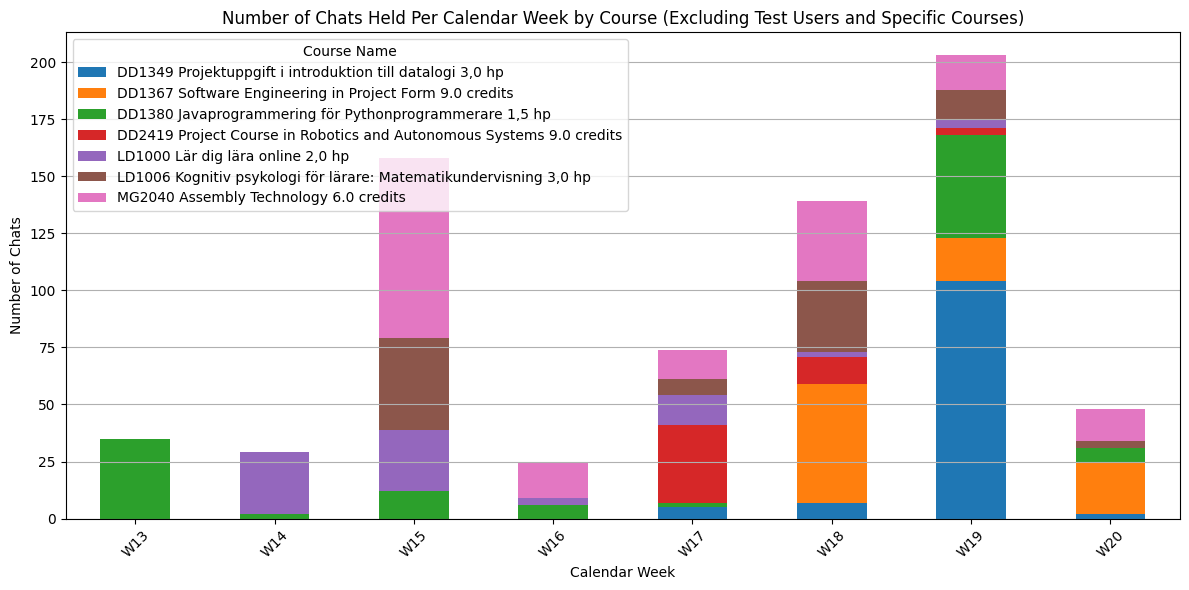

In [61]:
df_chats = dataframes['chats']
df_sessions = dataframes['sessions']
df_courses = dataframes['courses']

df_chats['created_at'] = pd.to_datetime(df_chats['created_at'])

df_merged = pd.merge(df_chats, df_sessions[['id', 'is_test_user']], left_on='session_id', right_on='id', how='left')

df_filtered = df_merged[df_merged['is_test_user'] == False].copy()

# Exclude ID 1: DD2445 Complexity Theory 7.5 credits
# Exclude ID 6: DA231X Degree Project in Computer Science and Engineering, Second Cycle 30.0 credits
# These were just used for testing, not actually included in the study
df_filtered = df_filtered[~df_filtered['course_id'].isin([1, 6])]

df_filtered_with_names = pd.merge(df_filtered, df_courses, left_on='course_id', right_on='id', how='left', suffixes=('', '_course'))

df_filtered_with_names['week'] = df_filtered_with_names['created_at'].dt.strftime('W%U')
chats_per_week_per_course = df_filtered_with_names.groupby(['name', 'week']).size().unstack(fill_value=0)

plt.figure(figsize=(12, 6))
chats_per_week_per_course.T.plot(kind='bar', stacked=True, figsize=(12, 6))

plt.title('Number of Chats Held Per Calendar Week by Course (Excluding Test Users and Specific Courses)')
plt.xlabel('Calendar Week')
plt.ylabel('Number of Chats')
plt.legend(title='Course Name')
plt.grid(axis='y')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

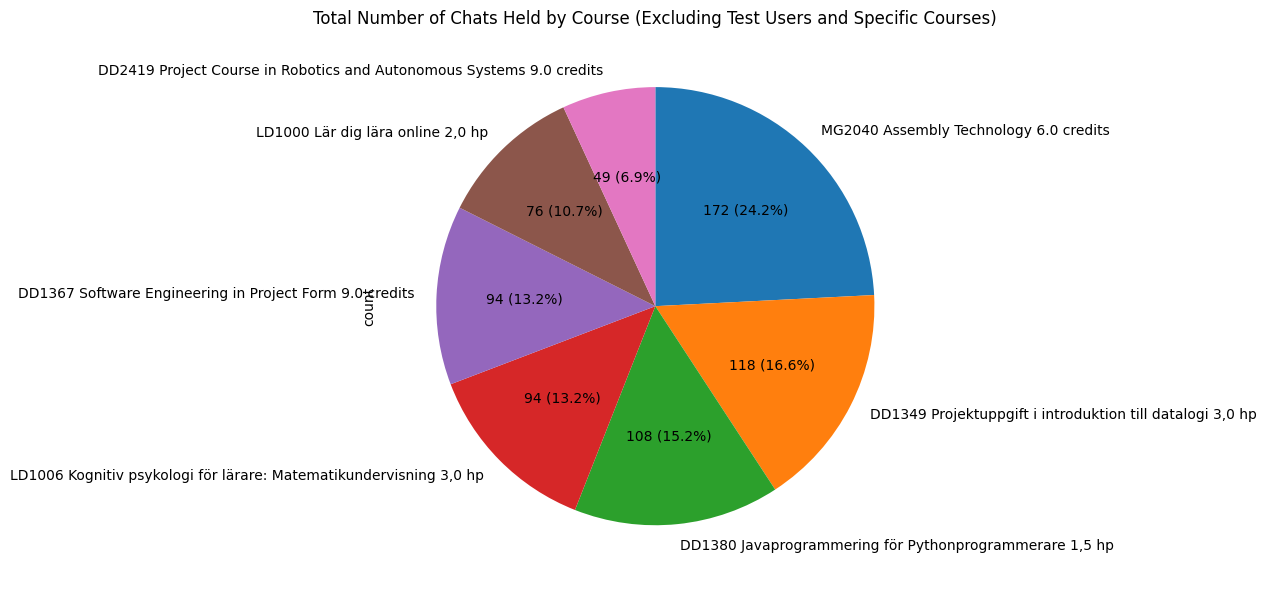

In [63]:
df_chats = dataframes['chats']
df_sessions = dataframes['sessions']
df_courses = dataframes['courses']

df_chats['created_at'] = pd.to_datetime(df_chats['created_at'])

df_merged = pd.merge(df_chats, df_sessions[['id', 'is_test_user']], left_on='session_id', right_on='id', how='left')

df_filtered = df_merged[df_merged['is_test_user'] == False].copy()

df_filtered = df_filtered[~df_filtered['course_id'].isin([1, 6])]

df_filtered_with_names = pd.merge(df_filtered, df_courses, left_on='course_id', right_on='id', how='left', suffixes=('', '_course'))

total_chats_per_course = df_filtered_with_names['name'].value_counts()

plt.figure(figsize=(12, 6))
total_chats_per_course.plot(kind='pie', autopct=lambda p: '{:.0f} ({:.1f}%)'.format(p * total_chats_per_course.sum() / 100, p), startangle=90, counterclock=False)

plt.title('Total Number of Chats Held by Course (Excluding Test Users and Specific Courses)')
plt.tight_layout()
plt.show()